In [3]:
import os
from io import BytesIO
from pathlib import Path
from uuid import uuid4 as uuid

# import numpy as np
import pandas as pd
import seaborn as sns ## Exploration
import matplotlib.pyplot as plt ## Exploration

from PIL import Image
from dotenv import load_dotenv
from helpers import collectImage, callAPI
import secrets

In [4]:
load_dotenv()

dataPath = Path(os.getenv('WALLPAPER_PATH'))
deselectedPath = Path(os.getenv('DESELECTED_PATH'))
storagePath = Path(os.getenv('STORAGE_PATH'))

if not (dataPath/deselectedPath).exists(): (dataPath/deselectedPath).mkdir()
if not (dataPath/storagePath).exists(): (dataPath/storagePath).mkdir()

targetFiles = sorted(
    list((dataPath/'Desktop').glob('*.png')) + 
    list((dataPath/'Desktop').glob('*.jpg')))

targetFiles = list(map( lambda x: 'Desktop/'+ x.parts[-1], targetFiles))

len(targetFiles)

215

In [2]:
def getDimensions(filename):
    return (*Image.open(filename).size, filename)

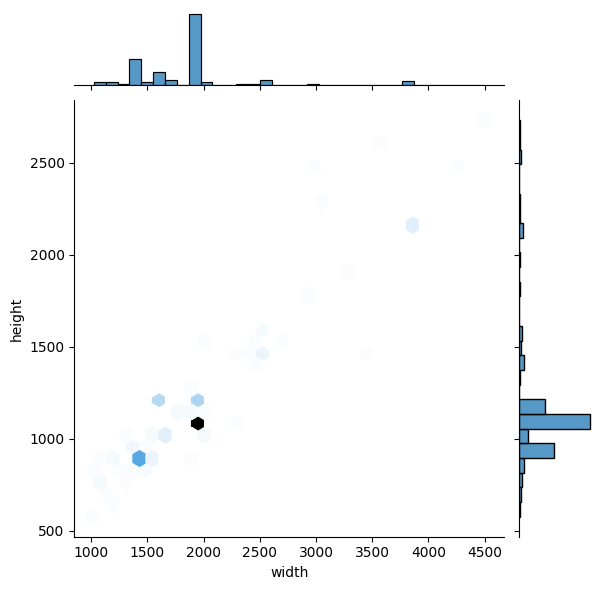

In [5]:
# Check my own wallpaper dimensions:
resolutions = list(map( getDimensions, map(lambda x: dataPath/x, targetFiles)))
data = pd.DataFrame(resolutions, columns=['width', 'height', 'filename'])
sns.jointplot(data, x='width', y='height', kind='hex');

## API stuff

In [6]:
import json
import requests

wallpaperAPI = 'https://wallhaven.cc/api/v1/search?'
resolution = '1920x1080'
qResolution = f'resolution={resolution}'
ratio ='16x9'
qRatio = f'ratios={ratio}'

In [7]:
# # 16/9.0
wallpaperAPI + qRatio

'https://wallhaven.cc/api/v1/search?ratios=16x9'

In [6]:
r = requests.get(wallpaperAPI + qRatio)

In [8]:
tmp = pd.DataFrame(json.loads(r.content)['data'])
#tmp.head(10)
tmp = tmp.assign(
    ratio = tmp.ratio.astype(float)
)
tmp[['id', 'url', 'resolution', 'ratio', 'file_type', 'path']].head()

,id,url,resolution,ratio,file_type,path
0,p97q3p,https://wallhaven.cc/w/p97q3p,1920x1080,1.78,image/jpeg,https://w.wallhaven.cc/full/p9/wallhaven-p97q3...
1,gpmozd,https://wallhaven.cc/w/gpmozd,3840x2160,1.78,image/jpeg,https://w.wallhaven.cc/full/gp/wallhaven-gpmoz...
2,jxym9y,https://wallhaven.cc/w/jxym9y,3840x2160,1.78,image/jpeg,https://w.wallhaven.cc/full/jx/wallhaven-jxym9...
3,l8j592,https://wallhaven.cc/w/l8j592,3840x2160,1.78,image/jpeg,https://w.wallhaven.cc/full/l8/wallhaven-l8j59...
4,yx2y7g,https://wallhaven.cc/w/yx2y7g,3840x2160,1.78,image/jpeg,https://w.wallhaven.cc/full/yx/wallhaven-yx2y7...


In [9]:
# Testing to pull urls from the results.
# for _, item in tmp[ tmp.category == 'anime'][['path']].items():
#     print( item.values )

['https://w.wallhaven.cc/full/vq/wallhaven-vqdljm.png'
 'https://w.wallhaven.cc/full/5g/wallhaven-5gmoq7.png'
 'https://w.wallhaven.cc/full/3l/wallhaven-3l6j89.png'
 'https://w.wallhaven.cc/full/x6/wallhaven-x6dg23.png'
 'https://w.wallhaven.cc/full/ex/wallhaven-ex6l1r.png'
 'https://w.wallhaven.cc/full/p9/wallhaven-p97zxm.png'
 'https://w.wallhaven.cc/full/m3/wallhaven-m3gemy.png'
 'https://w.wallhaven.cc/full/gp/wallhaven-gpmglq.png'
 'https://w.wallhaven.cc/full/ex/wallhaven-ex6lvw.jpg'
 'https://w.wallhaven.cc/full/p9/wallhaven-p97zmj.png'
 'https://w.wallhaven.cc/full/5g/wallhaven-5gmo31.jpg']


In [7]:
# Collect a set of images from the API
## random seed does not work

imgs = []
frames = []
count = 1

while len(imgs) < 100:
    r = requests.get( wallpaperAPI + qRatio + f'&page={count}')
    tmp = pd.DataFrame(json.loads(r.content)['data'])

    frames += [tmp]
    collection = [ collectImage( url ) for _, url in tmp.path.items() ]
    imgs = imgs + collection
    print(f'Length of the collection is {len(imgs)}.')
    count += 1

# Join all the collected image data as a dataframe
df = pd.concat(frames).reset_index(drop=True)

Length of the collection is 24.
Length of the collection is 48.
Length of the collection is 72.
Length of the collection is 96.
Length of the collection is 120.


In [8]:
df.id.nunique(), len( df )

(120, 120)

In [10]:
for i,r in df.iterrows():
    imgs[i].save(
        str(storagePath) + '/' + str(i).zfill(4) + '.' + r.file_type.split('/')[-1]
    )

## Building CSV

In [26]:
# Setup versions
template = pd.DataFrame(columns=['fname', 'label'])

# labels will be the final; downloaded is filled out by me.
labels = template.copy()
downloaded = template.copy()
removed = template.copy()

In [71]:
# Remove wallpapers I don't care about anymore
removedFiles = sorted(
    [ '/'.join(f.parts[-3:]) for f in (dataPath/deselectedPath).iterdir() ],
    key = lambda x: x.split('/')[-1])
removed['fname'] = removedFiles
removed['label'] = 'NO'

In [54]:
downloadedFiles = sorted(
    [ '/'.join(f.parts[-3:]) for f in (dataPath/storagePath).iterdir() ],
    key = lambda x: x.split('/')[-1])
downloaded['fname'] = downloadedFiles
downloaded.to_csv(dataPath/'model/downloaded.csv', index=False)

In [58]:
filledOut = pd.read_csv(dataPath/'model/downloaded.csv')
filledOut.head()

,fname,label
0,model/storage/0000.jpeg,NO
1,model/storage/0001.jpeg,NO
2,model/storage/0002.png,NO
3,model/storage/0003.png,NO
4,model/storage/0004.png,NO


In [59]:
labels['fname'] = targetFiles
labels['label'] = 'YES'

In [75]:
selections = pd.concat([labels, filledOut, removed])
selections.label.value_counts()

label
YES    223
NO     109
Name: count, dtype: int64

## Compression, Storage and Recall
### TODO later

In [17]:
import pickle
import bz2
import gzip
import lzma

# meh
with gzip.open("gzip_test.gz", "wb") as f:
    pickle.dump(imgs[0], f)

# second best but mostly the same and much faster
with bz2.BZ2File('bz2_test.pbz2', 'wb') as f:
    pickle.dump(imgs[0], f)

# Winner but slow
with lzma.open("lzma_test.xz", "wb") as f:
    pickle.dump(imgs[0], f)

## Model Building

In [62]:
from fastcore.all import *
from fastai.vision.all import *     # This is for the CNN learner.

In [76]:
dls = ImageDataLoaders.from_df(selections, dataPath, item_tfms=Resize((1080//4, 1920//4)))

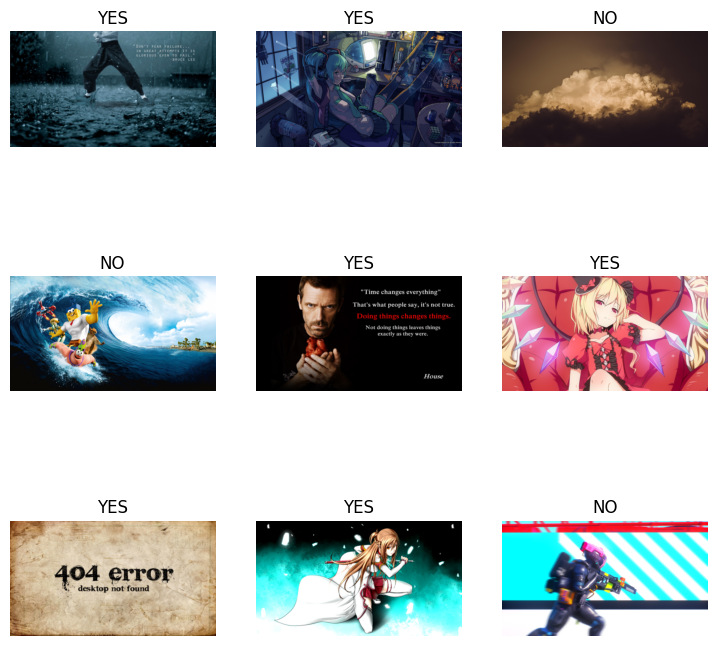

In [77]:
dls.show_batch()

In [116]:
# semicolon is to suppress warnings here
# .to_fp16() actually made this even worse then it was, somehow
learn = vision_learner(dls, resnet34, metrics=error_rate);

SuggestedLRs(valley=0.0006918309954926372)

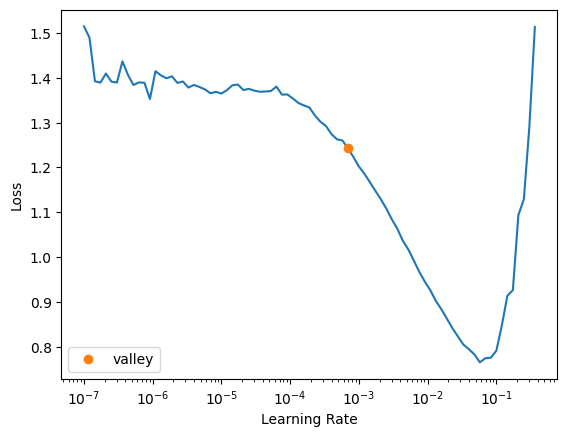

In [117]:
learn.lr_find();

In [118]:
# This is overfitting pretty badly; will need to fix this
## Weight decay makes this even worse
## I ended up extending out the number of cycles since I was making solid gains to validation loss
###  as I trained it but started overfitting again at ~25% error rate
learn.fine_tune(12, .0006)

epoch,train_loss,valid_loss,error_rate,time
0,1.376086,1.093225,0.515152,00:08


epoch,train_loss,valid_loss,error_rate,time
0,1.115454,0.867712,0.484848,00:08
1,1.106222,0.780256,0.454545,00:08
2,1.024022,0.662568,0.348485,00:09
3,0.938420,0.596461,0.287879,00:08
4,0.833745,0.596598,0.257576,00:09
5,0.740805,0.589031,0.272727,00:08
6,0.655712,0.592643,0.272727,00:09
7,0.583389,0.584609,0.257576,00:08
8,0.531508,0.580853,0.257576,00:08
9,0.478996,0.579825,0.272727,00:08


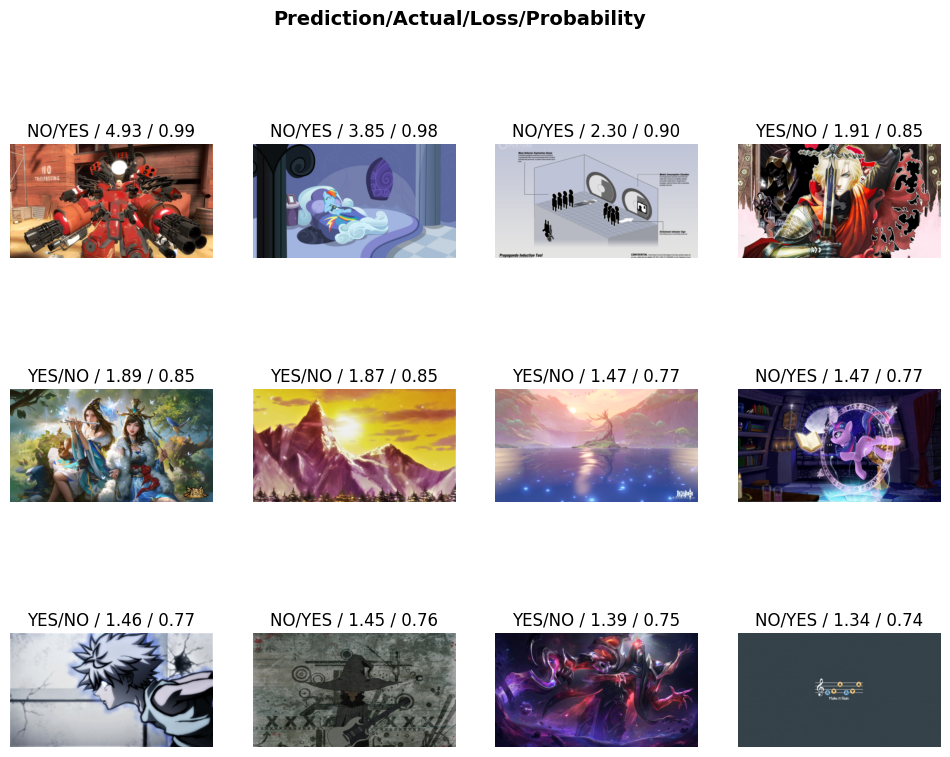

In [119]:
interp = Interpretation.from_learner(learn)
interp.plot_top_losses(12)

In [120]:
modelName = 'prototype'
modelPath = dataPath/f'model/{modelName}'
learn.export(modelPath)

In [141]:
nLearn = load_learner(modelPath)
print(nLearn.predict(dataPath/targetFiles[0])[0])

YES


# Testing

In [59]:
r = requests.get( wallpaperAPI + qRatio + f'&page=7')
tmp = pd.DataFrame(json.loads(r.content)['data'])

for i,r in tmp.iterrows():
    img = collectImage(r.path)
    img.save(str(storagePath/r.id) + '.' + r.file_type.split('/')[-1])

In [ ]:
# we'll need a way to mark these files:
# aa_<id>

for file in (dataPath/'tmp').glob("*[jpeg|png]"):
    prediction = learn.predict(file)[0].strip()
    if prediction == 'YES':
        print( file.parts )


# learn.predict(dataPath/)[0]